Epoch 1/50, Training Loss: 0.3256513038407201, Validation Loss: 0.2960840572975694
Epoch 2/50, Training Loss: 0.185511521541554, Validation Loss: 0.23679705068632043
Epoch 3/50, Training Loss: 0.15175794686960137, Validation Loss: 0.2046961420856135
Epoch 4/50, Training Loss: 0.1273944651303084, Validation Loss: 0.16612016535374427
Epoch 5/50, Training Loss: 0.11943950698427531, Validation Loss: 0.15237683657733647
Epoch 6/50, Training Loss: 0.11457184151462886, Validation Loss: 0.12261848613373538
Epoch 7/50, Training Loss: 0.10455296959566034, Validation Loss: 0.14974714700397182
Epoch 8/50, Training Loss: 0.10120980059323104, Validation Loss: 0.10927332440630658
Epoch 9/50, Training Loss: 0.09231220367162124, Validation Loss: 0.10773223137439299
Epoch 10/50, Training Loss: 0.09058503482652747, Validation Loss: 0.09890112261681776
Epoch 11/50, Training Loss: 0.09017220761464989, Validation Loss: 0.10587244623207936
Epoch 12/50, Training Loss: 0.08863553728746332, Validation Loss: 0.0

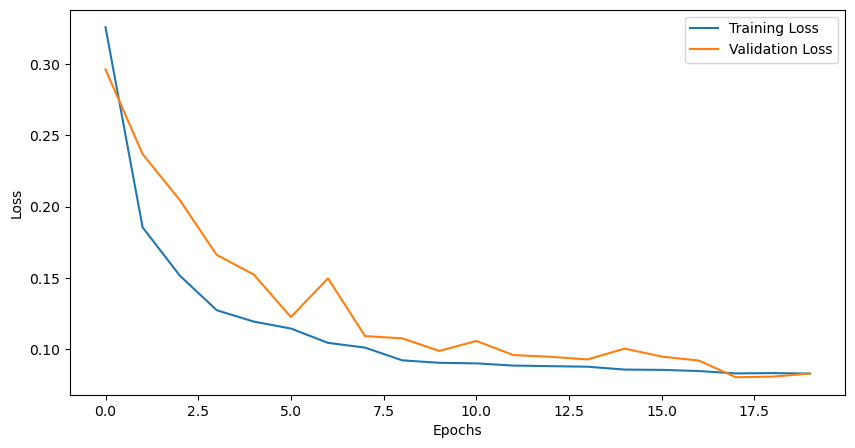

First 5 predictions: [[-0.573661   -0.57343173 -0.57144964 -0.57206553 -0.5722797  -0.5739932
  -0.5737459  -0.5446402  -0.47988895 -0.41147366 -0.26921013 -0.10479054
   0.12448253  0.3864414   0.6834987   1.1844972   1.7402234   2.553543
   2.9691155   3.1564093 ]
 [-0.5508855  -0.54613435 -0.55685264 -0.5574563  -0.5607234  -0.54981554
  -0.550927   -0.54256725 -0.49117997 -0.4158404  -0.30553782 -0.18163687
  -0.01924184  0.15767244  0.2920989   0.43643597  0.643361    0.96419144
   1.1233184   1.2318832 ]
 [-0.5351251  -0.5289215  -0.548934   -0.549116   -0.55585694 -0.53618807
  -0.540039   -0.5437824  -0.5219545  -0.49175915 -0.455924   -0.409472
  -0.3332817  -0.26938534 -0.20610437 -0.12631851 -0.01751688  0.15699749
   0.2463899   0.26220053]
 [-0.55209    -0.5492983  -0.55801845 -0.55857414 -0.5618279  -0.55276984
  -0.55445814 -0.55058473 -0.52298015 -0.48455638 -0.43329397 -0.3634375
  -0.26053157 -0.1475513  -0.04246834  0.08457145  0.2968917   0.6358874
   0.7705829   0.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Cargar los DataLoaders
train_loader = torch.load('train (2).pth', map_location=torch.device('cpu'))
val_loader = torch.load('val (2).pth', map_location=torch.device('cpu'))
test_loader = torch.load('test (2).pth', map_location=torch.device('cpu'))

# Parámetros de la red
input_size = 6001
hidden_size = [1024, 512, 256, 128]  # Ajustado
output_size = 20
learning_rate = 0.0008  # Ajustado
num_epochs = 50  # Ajustado
weight_decay = 1e-4

# Definir el modelo MLP
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(hidden_size[2], hidden_size[3])
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(hidden_size[3], output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout4(x)
        x = self.fc5(x)
        return x

# Crear el modelo
model = SimpleMLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Función de entrenamiento
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

        # Early stopping
        if epoch > 10 and val_losses[-1] > val_losses[-2] > val_losses[-3]:
            print(f'Early stopping on epoch {epoch+1}')
            break

    return train_losses, val_losses

# Entrenar el modelo
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Evaluar el modelo
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions.append(outputs.numpy())
            true_values.append(targets.numpy())

    predictions = np.concatenate(predictions)
    true_values = np.concatenate(true_values)

    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    
    # Calcular el R² promedio
    r2_scores = [r2_score(true, pred) for true, pred in zip(true_values, predictions)]
    r2_average = np.mean(r2_scores)

    print(f'Mean Absolute Error: {mae}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Average R² Score: {r2_average}')

    return predictions, true_values

# Evaluar y obtener predicciones
predictions, true_values = evaluate_model(model, test_loader)

# Graficar las pérdidas de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Mostrar las primeras 5 predicciones y valores reales
print(f'First 5 predictions: {predictions[:5]}')
print(f'First 5 true values: {true_values[:5]}')


In [4]:
import numpy as np
from scipy.stats import pearsonr

pearson_corrs = []
r2_scores = []

for i in range(true_values.shape[0]):
    pearson_corr = np.corrcoef(true_values[i], predictions[i])[0, 1]
    r2 = pearson_corr ** 2
    pearson_corrs.append(pearson_corr)
    r2_scores.append(r2)

# Calcular el R² global como la media de todos los R²
global_r2 = np.mean(r2_scores)

print(f"Global R²: {global_r2}")

Global R²: 0.9040590932645549
